In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from net import NeuralNet
from utils import *
import mnist_loader
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import bernoulli

In [3]:
training_data, validation_data, test_data = mnist_loader.load_data()

In [4]:
X_train, y_train = training_data[0].T, training_data[1].T
X_valid, y_valid = validation_data[0].T, validation_data[1].T
X_test, y_test = test_data[0].T, test_data[1].T
y_train_1hot = one_hot(y_train, 10)
y_valid_1hot = one_hot(y_valid, 10)
y_test_1hot = one_hot(y_test, 10)

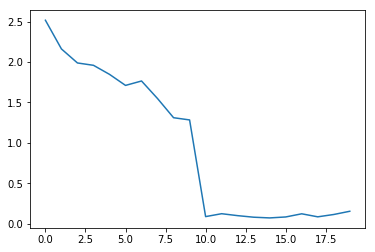

In [245]:
net_valid = NeuralNet(sizes=[784, 400, 10], dropout=True, eta=0.001, epochs=150, batch_size=1024)
net_valid.fit(X_valid, y_valid_1hot)
plt.plot(net_valid.costs)

In [246]:
net_valid.accuracy(X_valid, y_valid)

99.27

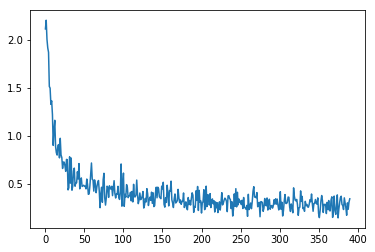

In [217]:
net = NeuralNet(sizes=[784, 256, 10], dropout=(0.9, 0.6), eta=0.0009, epochs=5, batch_size=128)
net.fit(X_train, y_train_1hot)
plt.plot(net.costs)

In [218]:
net.accuracy(X_train, y_train)

97.11

In [219]:
net.accuracy(X_test, y_test)

96.4